# Text classification with BERT

This notebook briefly demonstrates fine-tuning a pretrained BERT model to a text classification task.

You probably want to run this notebook with GPU acceleration, as fine-tuning BERT on CPU can be fairly slow even with a comparatively small dataset.

## Configuration

The following variables configure a few aspects of the data, model, and training process. To adapt this example to a different dataset, you'll probably want to change these to match.

Note in particular that we're limiting the number of examples and the maximum sequence length to make training faster. 

When running on GPU, it's also necessary to make sure that the input length and batch size are not so large as to cause a batch to exceed GPU memory. If you're getting a message like `Resource exhausted: OOM when allocating tensor`, try smaller numbers for these.

In [1]:
%tensorflow_version 1.x
import os
os.environ['TF_KERAS'] = '1'    # Required to use tensorflow.python.keras with keras-bert'

TensorFlow 1.x selected.


In [2]:
# Maximum number of examples to read
MAX_EXAMPLES = 5000

# Maximum length of input sequence in tokens
INPUT_LENGTH = 250

# Number of epochs to train for
EPOCHS = 3

# Optimizer learning rate
LEARNING_RATE = 0.00002

# Training batch size
BATCH_SIZE = 8

## Package setup

We'll use [keras-bert](https://github.com/CyberZHG/keras-bert). Make sure the package is installed. (`pip` is the Python [package installer](https://pip.pypa.io/en/stable/))

In [ ]:
!pip3 install keras-bert

## Tensorflow configuration

We'll need set an environment variable for keras-bert to use `tensorflow.python.keras`. (This is a technical detail that is not related to the model.)

## Download dataset

We'll use the IMDB dataset in JSON format. (This should be familiar to you from previous notebooks in this course.)

In [4]:
#Gdown is a utility for downloading large files from Google Drive, where I mirrored the NER trained model for you

!pip install gdown
!gdown -O fincore_5k_sample.txt 'https://drive.google.com/uc?export=download&id=1-1J3ieUyYsRj2TGvsmimxh7RAQFndaVu'

Downloading...
From: https://drive.google.com/uc?export=download&id=1-1J3ieUyYsRj2TGvsmimxh7RAQFndaVu
To: /content/fincore_5k_sample.txt
4.65MB [00:00, 72.3MB/s]


## Load data

Load a sample of the FinCORE corpus. It comes in the form "label TAB text". There is 8 main labels and another about 30 combinations of these 8 main labels (multilabel problem)


Separate the texts and labels into lists of their own.

In [6]:
import random
random.seed(1234)
texts=[]
labels=[]
with open("fincore_5k_sample.txt") as f:
    lines=f.readlines()
    random.shuffle(lines)
    for line in lines[:MAX_EXAMPLES]:
        line=line.rstrip("\n")
        lab,txt=line.split("\t")
        texts.append(txt)
        labels.append(lab)

# Example text and label
print('Text:', texts[0])
print('Label:', labels[0])

Text: Harjoittelu Alla on Psylin opiskelijatoimikunnan määritelmä harjoittelun tavoitteista sekä Psylin palkkasuositus , joka tulee pitää mielessä harjoittelupaikkaa etsiessä . Harjoittelun ei tule olla huonosti palkattua saati palkatonta . Palkkojen poljenta ei aja minkään tahon etuja ja vastaavasti palkka-asioiden hoitaminen suositusten mukaisesti on signaali kestävästä ja ammattitaitoa arvostavasta kehityksestä . HARJOITTELUN TAVOITTEET JA SISÄLLÖT Harjoittelun keskeisenä tavoitteena on kehittää psykologin työtehtävissä tarvittavia ammatillisia valmiuksia sekä ammatti-identiteettiä . Harjoittelussa opiskelija perehtyy yksilön ja yhteisön arviointiin , ohjaus- , neuvonta- , hoito- ja kuntoutusmenetelmiin , psykologisten palvelujen järjestelmien toimintaan sekä psykologin työn eettisiin lähtökohtiin ja velvoitteisiin . Hän oppii käyttämään jo omaksumiaan tietoja ja taitoja käytännön työtilanteessa , oppii uusia työtaitoja ja tietää , mitä tietoja ja taitoja hän tarvitsee voidakseen ke

## Download pretrained BERT model

As training BERT from scratch generally takes days, we'll here load a pretrained model and fine-tune it for our task. URLs to download pre-trained models made available by Google are found at https://github.com/google-research/bert .




In [7]:
# Give -nc (--no-clobber) argument so that the file isn't downloaded multiple times 
#!wget -nc http://dl.turkunlp.org/finbert/bert-base-finnish-cased-v1.zip

!gdown -O bert-base-finnish-cased-v1.zip  'https://drive.google.com/uc?export=download&id=1y-5vAqyWP24Tm_VBsbaXBXnIddUKck-5'

Downloading...
From: https://drive.google.com/uc?export=download&id=1y-5vAqyWP24Tm_VBsbaXBXnIddUKck-5
To: /content/bert-base-finnish-cased-v1.zip
1.37GB [00:08, 155MB/s]


Unpack the downloaded file:

In [8]:
# Give -n argument so that existing files aren't overwritten 
!unzip -n bert-base-finnish-cased-v1.zip

Archive:  bert-base-finnish-cased-v1.zip
  inflating: bert-base-finnish-cased-v1/bert_config.json  
  inflating: bert-base-finnish-cased-v1/bert_model.ckpt.data-00000-of-00001  
  inflating: bert-base-finnish-cased-v1/bert_model.ckpt.index  
  inflating: bert-base-finnish-cased-v1/bert_model.ckpt.meta  
  inflating: bert-base-finnish-cased-v1/vocab.txt  


There are three key parts to the package contents:

* `vocab.txt`: plain text file listing vocabulary items
* `bert_config.json`: model configuration in JSON format
* `bert_model.ckpt.*`: model checkpoint data with pre-trained weights in [Tensorflow checkpoint format](https://www.tensorflow.org/guide/checkpoint)

Take note of the path to these (you'll need to change this if you pick a different model)

In [9]:
bert_vocab_path = 'bert-base-finnish-cased-v1/vocab.txt'
bert_config_path = 'bert-base-finnish-cased-v1/bert_config.json'
bert_checkpoint_path = 'bert-base-finnish-cased-v1/bert_model.ckpt'    # suffixes not required

Also take note if the model we downloaded was a case-sensitive (cased) or not. (This must match the model.)

In [10]:
model_is_cased = True

## Load BERT vocabulary

This is just a plain text file with one vocabulary item per line.

In [11]:
vocab = []
with open(bert_vocab_path) as f:
    for i, line in enumerate(f):
        vocab.append(line.rstrip('\n'))    # rstrip to remove newline characters


# Print a list with every 500th vocabulary item
print(vocab[0::500])

['[PAD]', '##hin', '##tila', 'tehtä', '##ce', 'avulla', '##uttua', 'Sil', '##iver', 'tarvits', 'kilometrin', 'sanotaan', '##ya', 'onnistuu', 'tapaus', 'rento', '##otin', '##kasvat', 'kauhe', 'puolin', 'ymmärrän', 'polttoain', 'arvot', 'ajattelu', '##impiin', 'huomasi', 'tietokoneen', 'tiedämme', 'johdossa', 'teemme', 'paikallisen', 'rekryt', 'vuosikymmeniä', 'kohdistuu', 'tyhmiä', 'baa', '##ipa', 'aero', '##ehtien', 'viimeisteli', '##llosta', 'luulevat', 'verenpain', 'tuottamaan', 'vahingot', 'opiskelijan', '##päivinä', '##uksellisesti', 'uskottava', '##elemaan', 'ilmennyt', 'määrätieto', 'leppo', 'yksityiset', 'kirjailijan', 'vastikään', 'samoista', '##misiin', '##pankkien', 'tuut', 'muutoinkin', 'säilyi', '##ivuoren', '##pauksia', 'kaupungilta', '##lalle', 'tervetulleeksi', 'lähteitä', 'isoin', 'Tuskinpa', 'hallinnut', '##kanslerin', '##jela', 'siniset', 'erikoiskokeella', 'todistavat', 'itsehallinto', 'Oran', 'vikaan', 'ISIS', 'hankinnan', '##eleitä', '##heitolla', '##upar', 'raam',

## Load BERT configuration

The configuration is just a JSON file, so we can read it in with `json.load` from the python `json` library.

We won't actually need to use these configuration details directly (keras-bert takes care of them for us), so this is just here to show what information is contained in the config file.

In [13]:
from pprint import pprint    # pretty-printer for output
import json

with open(bert_config_path) as f:
    config = json.load(f)


# Print configuration contents
pprint(config)

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 50105}


## Create BERT tokenizer

To create the tokenizer, we'll need a mapping from vocabulary items to their corresponding integer indices. We do this conventionally using `enumerate`.

In [14]:
# Create mapping from vocabulary items to their indices in the vocabulary
token_dict = { v: i for i, v in enumerate(vocab) }


# Print some random examples of the mapping
pprint(dict(random.choices(list(token_dict.items()), k=10)))

{'##FO': 40995,
 '##itis': 24541,
 '##tiede': 36700,
 '##vä': 212,
 '##yhteydet': 23184,
 'Rinteen': 29435,
 'bus': 11652,
 'parisuhdetta': 30697,
 'taajuus': 46190,
 'uusista': 11335}


We'll use the keras-bert `Tokenizer` for BERT tokenization. The implementation supports

* (Optional) lowercasing: `Hello` → `hello`
* Basic tokenization: `Hello!` → `Hello` `!`, `multi-part` → `multi` `-` `part`
* Wordpiece tokenization: `comprehensively` → `comprehensive` `##ly`
* Adding special tokens: `Sentence`  → `[CLS]` `Sentence` `[SEP]`
* Mapping to integer indices
* Generating segment sequence
* (Optional) padding and truncation to length

In the following example, notice how words not in the dictionary are broken up into subwords (with continuation parts starting with `##`) and how unknown _characters_ are mapped to a special unknown word token `[UNK]`.

In [15]:
from keras_bert import Tokenizer


tokenizer = Tokenizer(token_dict, cased=model_is_cased)


# Let's test that out
for s in ['Terve BERT! Hauskaa tavata!', 'Tuntematon: 你']:
    print('Original string:', s)
    print('Tokenized:', tokenizer.tokenize(s))
    indices, segments = tokenizer.encode(s, max_len=20)    # max_len for padding and truncation
    print('Encoded:', indices)
    print('Segments:', segments)
    print('Decoded:', ' '.join(tokenizer.decode(indices)))
    print()

Original string: Terve BERT! Hauskaa tavata!
Tokenized: ['[CLS]', 'Terve', 'B', '##ER', '##T', '!', 'Hauskaa', 'tavata', '!', '[SEP]']
Encoded: [102, 6309, 415, 9981, 50031, 380, 32676, 10594, 380, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Terve B ##ER ##T ! Hauskaa tavata !

Original string: Tuntematon: 你
Tokenized: ['[CLS]', 'Tunte', '##maton', ':', '你', '[SEP]']
Encoded: [102, 26356, 4763, 236, 101, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Tunte ##maton : [UNK]



## Vectorize data

We'll use the familiar `LabelEncoder` for labels and the keras-bert `Tokenizer` for text data. `Y` is the representation of the labels that will be given to the model for training.

In [16]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()    # Turns class labels into integers
Y = label_encoder.fit_transform(labels)

# Take note of how many unique labels there are in the data
num_labels = len(set(Y))


# Print out some examples
print('Number of unique labels:', num_labels)
print(type(labels), labels[:10])
print(type(Y), Y[:10])

Number of unique labels: 38
<class 'list'> ['IN', 'IN', 'IN', 'IN', 'IG', 'NA', 'IN', 'NA', 'ID', 'SP']
<class 'numpy.ndarray'> [12 12 12 12  8 21 12 21  4 37]


Keep token indices and segment ids in separate lists and store as numpy arrays. `X` here is the final vectorized form of the input we'll be providing to the model for training. 

In [17]:
import numpy as np


token_indices, segment_ids = [], []
for text in texts:
    # tokenizer.encode() returns a sequence of token indices
    # and a sequence of segment IDs. BERT expects both as input,
    # even if the segments IDs are just all zeros (like here).
    tid, sid = tokenizer.encode(text, max_len=INPUT_LENGTH)
    token_indices.append(tid)
    segment_ids.append(sid)

# Format input as list of two numpy arrays
X = [np.array(token_indices), np.array(segment_ids)]


# Print some examples
print('Token indices:')
print(X[0][:2])
print('Decoded:')
for i in X[0][:2]:
    print(tokenizer.decode(list(i)))
print('Segment ids:')
print(X[1][:2])

Token indices:
[[  102 16184   825 12725   145 16054  1037 11262 48314 28433 28813 28238
    612 16054  1037  3677 43268   794   119   374   650   751  4107 17193
   6719  3841   395   111 16184  3906   193   917   439  5827 35929 50006
  11570 11832  1810   111  1643 10208  1300   333   105   193  1939  4747
  40825 12046   142 13427  3677   166  6055 33193 46539  4332   145 41432
  11946   492   142 37481  7063  1904 19529   111 32513 39220 26310  2831
  26824 50045 16307 22389  7281  9064 12355 17448 24071 42365 16625 50098
  50031 16184  3906 38708  4846   145  6299 38965 50009 21147  2686 32779
   9615  1654 38348   612  3255   166 44140   111 16184  7504  7728  9506
   1025 13522   142 10625 39401   119  8720   166   119 29236   166   119
   4699   166   142 18779 11401  1732   119 38965 16410  9403 34353  5608
    612 38965 50009  1124 47231   174  2799 29410   142  8302  3480   111
    737 10568  7308   164 47431 16377  4689   142 16311  6597  8417 17178
    119 10568  2304 151

## Load pretrained BERT model

We'll use the keras-bert function `load_trained_model_from_checkpoint` to load the model from the checkpoint we downloaded earlier.

Explanation for a few parameters from keras-bert documentation:

* `training`: If `training`, the whole model will be returned. Otherwise, the MLM [masked language modeling] and NSP [next sentence prediction] parts will be ignored.
* `trainable`: Whether the model is trainable. The default value is the same with `training`.

We don't need the masked language modeling or next sentence prediction parts (these are primarily for pretraining), so we'll use `training=False` but `trainable=True`.

In [51]:
from keras_bert import load_trained_model_from_checkpoint


pretrained_model = load_trained_model_from_checkpoint(
    config_file = bert_config_path,
    checkpoint_file = bert_checkpoint_path,
    training = False,
    trainable = True,
    seq_len = INPUT_LENGTH
)

Let's have a bit of a look at that model

In [53]:
# This is a keras model, so we can figure out what inputs it takes like so:
pretrained_model.inputs

[<tf.Tensor 'Input-Token_2:0' shape=(?, 250) dtype=float32>,
 <tf.Tensor 'Input-Segment_2:0' shape=(?, 250) dtype=float32>]

In [54]:
# And similarly for outputs:
pretrained_model.outputs

[<tf.Tensor 'Encoder-12-FeedForward-Norm_2/add_1:0' shape=(?, 250, 768) dtype=float32>]

So, the model takes `Input-Token` and `Input-Segment` inputs, both of dimension (batch-size, input-length), and produces a single output tensor of dimension (batch-size, input-length, hidden-dim). The input matches our `X`, but we'll need to work on the output a bit as our `Y` is just a label for each input, not a sequence of labels.

In [55]:
pretrained_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 250)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 250)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 250, 768), ( 38480640    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 250, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

This is a regular Keras model. In Keras, models behave very much like layers, so we're able to wrap this in our own model.

## Build classification model

We'll make a *very* simple model for text classification: just attach a dense layer to the output for the special `[CLS]` token, and connect the model inputs to the BERT model inputs.

Recall that in the BERT input representation, each sequence starts with the special `[CLS]` token and the corresponding output is used in BERT pretraining for the next sentence prediction task. We'll use the `[CLS]` output similarly for our classification task.

<img src="https://raw.githubusercontent.com/TurkuNLP/Deep_Learning_in_LangTech_course/master/bert-representation.png" style="width: 80%">

(Figure from [Devlin et al.](https://arxiv.org/pdf/1810.04805.pdf))

First, let's find the output

In [56]:
print(pretrained_model.outputs)

[<tf.Tensor 'Encoder-12-FeedForward-Norm_2/add_1:0' shape=(?, 250, 768) dtype=float32>]


Those dimensions are (minibatch-size, sequence-length, hidden-dim).

We'll just need the first sequence position across all elements in the initial (minibatch) dimension:

In [57]:
# model.outputs is a list, here with a single item. Here
# pretrained_model.outputs[0] just grabs that item (the output tensor).
# Indexing that tensor with [:,0] gives the first position in the sequence
# for all elements in the batch (the `:`).
bert_out = pretrained_model.outputs[0][:,0]

print(bert_out)

Tensor("strided_slice_2:0", shape=(?, 768), dtype=float32)


Then we can simply create our model. This is just basic Keras, where the pretrained BERT model is behaving essentially as a layer of our "wrapping" model.

In [58]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense


out = Dense(num_labels, activation='softmax')(bert_out)
model = Model(
    inputs=pretrained_model.inputs,
    outputs=[out]
)

## Create optimizer

BERT is pretrained with an Adam optimizer with warmup and regularization using weight decay. We won't go into detail on these optimizer settings, but will instead largely copy parameters used in the original BERT work.

(If you're interested in tuning the training process, trying different values of `LEARNING_RATE` is a good place to start!)

In [59]:
from keras_bert import calc_train_steps, AdamWarmup


# Calculate the number of steps for warmup
total_steps, warmup_steps = calc_train_steps(
    num_example=len(texts),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    warmup_proportion=0.1,
)

optimizer = AdamWarmup(
    total_steps,
    warmup_steps,
    lr=LEARNING_RATE,
    epsilon=1e-6,
    weight_decay=0.01,
    weight_decay_pattern=['embeddings', 'kernel', 'W1', 'W2', 'Wk', 'Wq', 'Wv', 'Wo']
)

## Train model

The model is compiled and trained normally. As usual, we'll use `sparse_categorical_crossentropy` loss.

In [60]:
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

Training, as usual. (Note: this will take a fair bit of time unless you're running with GPU acceleration.)

In [61]:
history = model.fit(
    X,
    Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1
)

Train on 4500 samples, validate on 500 samples
Epoch 1/3
4500/4500 [==============================] - 350s 78ms/sample - loss: 1.3663 - sparse_categorical_accuracy: 0.6280 - val_loss: 0.9674 - val_sparse_categorical_accuracy: 0.7220
Epoch 2/3
4500/4500 [==============================] - 343s 76ms/sample - loss: 0.6605 - sparse_categorical_accuracy: 0.8040 - val_loss: 0.8256 - val_sparse_categorical_accuracy: 0.7460
Epoch 3/3
4500/4500 [==============================] - 345s 77ms/sample - loss: 0.3306 - sparse_categorical_accuracy: 0.9080 - val_loss: 0.8859 - val_sparse_categorical_accuracy: 0.7520


Let's plot that training history:

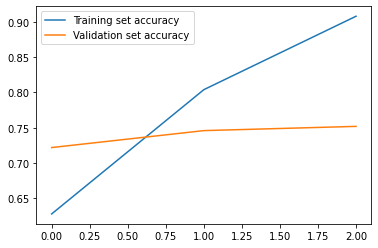

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_history(history):
    plt.plot(history.history['sparse_categorical_accuracy'],label="Training set accuracy")
    plt.plot(history.history['val_sparse_categorical_accuracy'],label="Validation set accuracy")
    plt.legend()
    plt.show()


plot_history(history)

This is definitely starting to overfit by the third epoch, but the best dev set result is well in line with the usual results on this data. 


## Predict with the trained model

Let's run a few simple cases through the trained model to illustrate its use.

In [63]:
import numpy

def predict_one(text):
    # This function takes a string, vectorizes it with the tokenizer,
    # and returns the model prediction. The vectorization follows
    # the pattern we saw above for training data preparation:
    tid, sid = tokenizer.encode(text, max_len=INPUT_LENGTH)
    test_token_indices = [tid]
    test_segment_ids = [sid]
    test_X = [np.array(test_token_indices), np.array(test_segment_ids)]
    # Run model.predict for this single case 
    predictions = model.predict(test_X)
    # model.predict always returns a sequence. As we there's only a single input,
    # we'll just return the value of the first (and only) element.
    return predictions[0]


# Test the model with a few strings of our own.
test_strings = [
  'Tämä on todella surkea elokuva!',
  'Vuonna 1939 alkoi talvisota, se kesti muutaman kuukauden.'
]

predictions=[]
for s in test_strings:
    predictions.append(numpy.argmax(predict_one(s)))
print(label_encoder.inverse_transform(predictions))
    

['OP' 'NA']
